<a href="https://colab.research.google.com/github/ernanhughes/boosting-examples/blob/main/Copy_of_XGBoost_%26_LightGBM_%26_Catboost_Imbalanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telco-customer-churn:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13996%2F18858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240729%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240729T200038Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc2832fd3d2821edd1e7792d20d31dfc2db2c839525cd24662d1ce237595ef6d4c6ca4a1a74ab6b1223d03185c8620e868a5fe2944b66fef9ed18fba22bfb4acca06357290f4b05cb152408436c3c548b9b3cc9ae90ac45333b03df7d7ecda5f0241fd8c0404516a17de64b863edc13ac7c21cd4264b6f4cc32f1c85f0efc63e837c75b8eb710c746124cf9d9eed83f9da9b271301c99205dda0a891124c978ea143af8cb3687e438d38a5011cc1c8b933befef5abe2b672f8d2c2e667db570b995b215f661885ee4d407b891307f2fcff5b63819599ba077e39da3ce5702c98a84f7454651961f8bb87685242f997289635b346cfc369b30467ef125e5a0872b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 175758 bytes downloaded
Downloaded and uncompressed: telco-customer-churn
Data source import complete.


<a id="toc"></a>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Contents</h3>
    
* [Data](#0)
* [What Problem We Have and Which Metric to Use?](#1)

* [Exploratory Data Analysis](#2)
    * [Target Variable](#3)
    * [Numerical Features](#4)
    * [Categorical Features](#5)
    * [Overall Insights](#6)
      
      
* [How Famous Trio (XGBoost & LightGBM & Catboost) Deal With Imbalanced Data?](#7)


* [CATBOOST](#8)
    * [CatBoost (with default Parameters) Deals With Imbalanced Data](#9)
    * [CatBoost (with adjusted Scale_Pos_Weight = 3) Deals With Imbalanced Data](#10)
    * [CatBoost (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data](#11)


* [XGBOOST](#12)    
    * [XGBoost (with default Parameters) Deals With Imbalanced Data](#13)    
    * [XGBoost (with adjusted Scale_Pos_Weight) Deals With Imbalanced Data](#14)
    * [XGBoost (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data](#15)


* [LightGBM](#16)
    * [LightGBM (with default Parameters) Deals With Imbalanced Data](#17)    
    * [LightGBM (with adjusted Scale_Pos_Weight) Deals With Imbalanced Data](#18)
    * [LightGBM (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data](#19)


* [Final Result Table and Model Comparison](#20)

* [Conclusion](#21)

* [Further Reading](#22)

<a id="0"></a>
<font color="Darkblue" size=+2.5><b>Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

# **Telco Customer Churn**

### **Data Dictionary**

1. **`CustomerID`**: A unique ID that identifies each customer.

2. **`Gender`**: The customer’s gender: Male, Female

3. **`Age`**: The customer’s current age, in years, at the time the fiscal quarter ended.

4. **`Senior Citizen`**: Indicates if the customer is 65 or older: Yes, No

5. **`Married (Partner)`**: Indicates if the customer is married: Yes, No

6. **`Dependents`**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

7. **`Number of Dependents`**: Indicates the number of dependents that live with the customer.

8. **`Phone Service`**: Indicates if the customer subscribes to home phone service with the company: Yes, No

9. **`Multiple Lines`**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

10. **`Internet Service`**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

11. **`Online Security`**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

12. **`Online Backup`**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

13. **`Device Protection Plan`**: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

14. **`Premium Tech Support`**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

15. **`Streaming TV`**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

16. **`Streaming Movies`**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

17. **`Contract`**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

18. **`Paperless Billing`**: Indicates if the customer has chosen paperless billing: Yes, No

19. **`Payment Method`**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

20. **`Monthly Charge`**: Indicates the customer’s current total monthly charge for all their services from the company.

21. **`Total Charges`**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

22. **`Tenure`**: Indicates the total amount of months that the customer has been with the company.

23. **`Churn`**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Reference:
https://www.kaggle.com/blastchar/telco-customer-churn

https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113



<a id="1"></a>
<font color="Darkblue" size=+1.5><b>What Problem We Have and Which Metric to Use?</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- Based on the data and data dictionary, We have a classification problem.
- We wil make classification on the target variable **`Churn`**
- And we will build a model to get best classification possible on the target variable.
- For that we will look at the balance of the target variable.
- As we will see later, our target variable has imblanced data
- For that reason we are not going to use Accuracy score,
- Based on the problem on the hand, we will use **`Recall score`**.
- [For the detailed info about the evaluation metrics](https://www.kaggle.com/kaanboke/the-most-common-evaluation-metrics-a-gentle-intro)

![](https://e7.pngegg.com/pngimages/301/649/png-clipart-snake-scale-measuring-scales-measurement-scale-light-fixture-measuring-scales-thumbnail.png)

Image Credit: https://e7.pngegg.com

<a id="2"></a>
<font color="Darkblue" size=+2.5><b>Exploratory Data Analysis</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- Let's import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve


import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier




#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

- Let's look at the data.

In [ ]:
pd.set_option('max_columns',100)
pd.set_option('max_rows',900)

pd.set_option('max_colwidth',200)

df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

- Duplicated and Missing Value check

In [ ]:
df.duplicated().sum()

0

In [ ]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

Missing_Number  Missing_Percent
customerID                     0              0.0
DeviceProtection               0              0.0
TotalCharges                   0              0.0
MonthlyCharges                 0              0.0
PaymentMethod                  0              0.0
PaperlessBilling               0              0.0
Contract                       0              0.0
StreamingMovies                0              0.0
StreamingTV                    0              0.0
TechSupport                    0              0.0
OnlineBackup                   0              0.0
gender                         0              0.0
OnlineSecurity                 0              0.0
InternetService                0              0.0
MultipleLines                  0              0.0
PhoneService                   0              0.0
tenure                         0              0.0
Dependents                     0              0.0
Partner                        0              0.0
SeniorCitizen                  0              0.0
Churn                          0              0.0

- Dataset does not have any duplicated and mising values. But don't be sure, always look deeper.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## After first sight, what we will do next?
-  We won't use **`customerID`**, so we will drop it.
- **`Total charges`** has object type we will change it to float type.
- **`Tenure`** has integer type we will change it to float type, for catboost model.
-  We will look at the cardinality of the categorical variables.
-  We will encode target variable (**`churn`**) to numeric type by using label encoding.

In [ ]:
df1 = df.drop('customerID',axis=1).copy()

- Data coding is always to be examined carefully.
- When we try to change the datatype of the `Total charges` from object type to float type, we will get error.
- Let's see what is the reason?

In [ ]:
df1['TotalCharges'][3826]

' '

- Even though we don't see any missing values, when we look at the data, `total charges` feature has missing values.

In [ ]:
df1.iloc[3826]

gender                             Male
SeniorCitizen                         0
Partner                             Yes
Dependents                          Yes
tenure                                0
PhoneService                        Yes
MultipleLines                       Yes
InternetService                      No
OnlineSecurity      No internet service
OnlineBackup        No internet service
DeviceProtection    No internet service
TechSupport         No internet service
StreamingTV         No internet service
StreamingMovies     No internet service
Contract                       Two year
PaperlessBilling                     No
PaymentMethod              Mailed check
MonthlyCharges                    25.35
TotalCharges                           
Churn                                No
Name: 3826, dtype: object

- We will make the correct coding to define misisng values.

In [ ]:
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

In [ ]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df1)

Missing_Number  Missing_Percent
TotalCharges                  11         0.001562
gender                         0         0.000000
SeniorCitizen                  0         0.000000
MonthlyCharges                 0         0.000000
PaymentMethod                  0         0.000000
PaperlessBilling               0         0.000000
Contract                       0         0.000000
StreamingMovies                0         0.000000
StreamingTV                    0         0.000000
TechSupport                    0         0.000000
DeviceProtection               0         0.000000
OnlineBackup                   0         0.000000
OnlineSecurity                 0         0.000000
InternetService                0         0.000000
MultipleLines                  0         0.000000
PhoneService                   0         0.000000
tenure                         0         0.000000
Dependents                     0         0.000000
Partner                        0         0.000000
Churn                          0         0.000000

- Even thoguh data has missing values, models which we will use in this study can handle the missing values internally.

<a id="3"></a>
<font color="Darkblue" size=+1.5><b>Target Variable</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
y = df1['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customer)\nPercentage of customer did not churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customer)')


Percentage of Churn:  26.54 %  --> (1869 customer)
Percentage of customer did not churn: 73.46  %  --> (5174 customer)


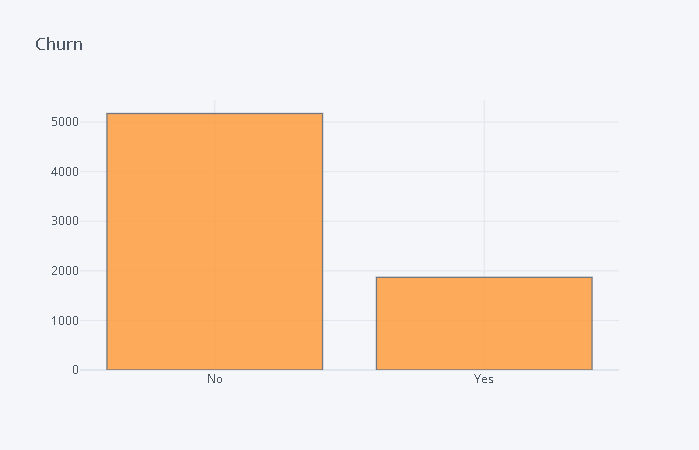

In [ ]:
y.iplot(kind='hist', title= 'Churn')

- We have imbalanced data.
- Almost 27% of the customers didn't continue with the company and churned.
- 1869 customer churned.
- Almost 73% of the customers continue with the company and didn't churn.
- 5174 customer didn't churn.


In [ ]:
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

- For further usage, let's get the list of the numerical and categorical features.

In [ ]:
numerical= df1.select_dtypes('number').columns

categorical = df1.select_dtypes('object').columns

print(f'Numerical Columns:  {df1[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df1[categorical].columns}')

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')


Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


<a id="4"></a>
<font color="Darkblue" size=+1.5><b>Numerical Features</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
df1['tenure']= df1['tenure'].astype(float)
numerical= df1.select_dtypes('number').columns

df1[numerical].describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn
count    7043.000000  7043.000000     7043.000000   7032.000000  7043.000000
mean        0.162147    32.371149       64.761692   2283.300441     0.265370
std         0.368612    24.559481       30.090047   2266.771362     0.441561
min         0.000000     0.000000       18.250000     18.800000     0.000000
25%         0.000000     9.000000       35.500000    401.450000     0.000000
50%         0.000000    29.000000       70.350000   1397.475000     0.000000
75%         0.000000    55.000000       89.850000   3794.737500     1.000000
max         1.000000    72.000000      118.750000   8684.800000     1.000000

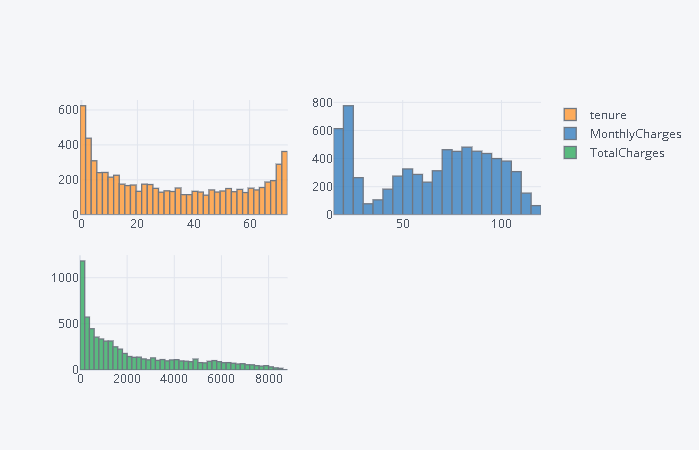

In [ ]:
df1[['tenure', 'MonthlyCharges', 'TotalCharges']].iplot(kind='histogram',subplots=True,bins=50)

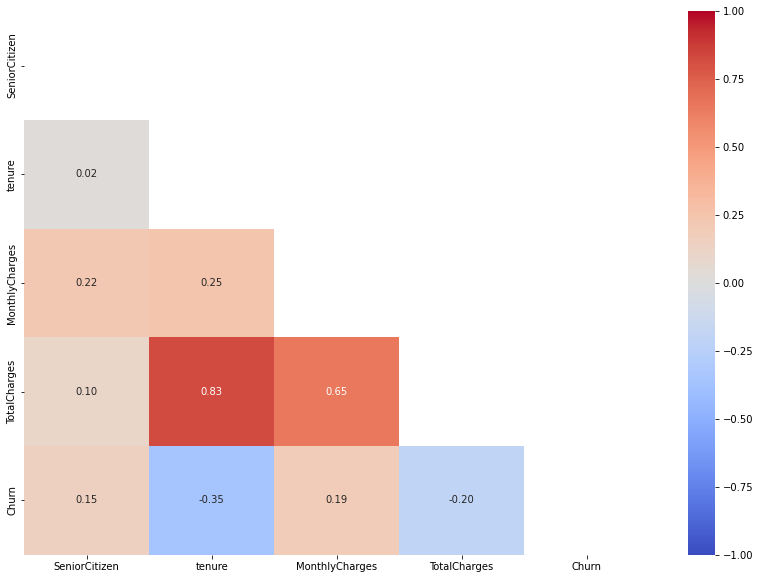

In [ ]:

matrix = np.triu(df1[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap (df1[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

* Based on the matrix, we can observe weak level correlation between the numerical features and the target variable
* There is strong correlation between tenure and total charges.
* Being senior citizen and increasing monthly charges have a positive correlation with the churn.
* Senior citizen more likely churn than younger customers.
* Customer with higher monthly charges also more likely churn than lesser monthly charges customers.
* Being long term with the company, customer less likely churn than customer  with lesser time with the company.
* Total charges has negative correlation with the churn.

<a id="5"></a>
<font color="Darkblue" size=+1.5><b>Categorical Features</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- Let's see cardinality of the categorical features.

In [ ]:
df1[categorical].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

- Data does not have a high cardinality or zero variance issues.

- Let's see the unique values of the categorical features.

In [ ]:
for feature in df1[categorical]:
        print(f'{feature}: {df[feature].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


- We can see that **`No internet service`** is repeating several times in the features and in this problem at hand, it gives same meaning as **No**
- So we can change them to **No** and then features will have two unique values,
- Also **`MultipleLines`** has **`No phone service`** option, which in this problem gives same meaning as **No** so we can change it to **No** and do the same thing for this feature.
- Lets'start with the bivariate analysis and on the way we will make the relevant changes.

### **Gender and Churn**

In [ ]:
print (f'A female customer has a probability of {round(df1[df1["gender"]=="Female"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A male customer has a probability of {round(df1[df1["gender"]=="Male"]["Churn"].mean()*100,2)} % churn')

print()

A female customer has a probability of 26.92 % churn

A male customer has a probability of 26.16 % churn



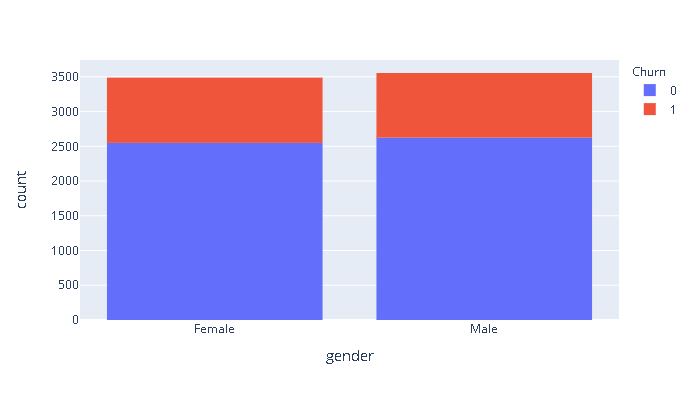

In [ ]:
fig = px.histogram(df1, x="gender", color="Churn",width=400, height=400)
fig.show()

- There is not much difference between gender on the churn rate.

### **Having Partner and Churn**

In [ ]:
print (f'A customer with a partner has a probability of {round(df1[df1["Partner"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any partner has a probability of {round(df1[df1["Partner"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a partner has a probability of 19.66 % churn

A customer without any partner has a probability of 32.96 % churn



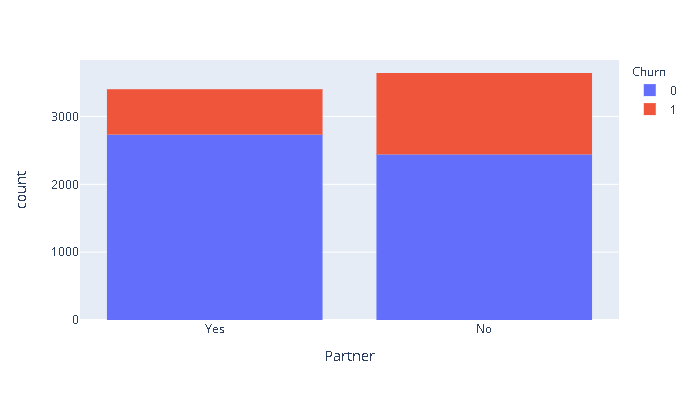

In [ ]:
fig = px.histogram(df1, x="Partner", color="Churn",width=400, height=400)
fig.show()

- Customer without any relationship, single customer almost 1.7 times more likely churn than cutomer with a partner.

![](https://media.giphy.com/media/Q9v2RwHugTfz39afpy/giphy.gif)

Gif Credit: https://media.giphy.com

### **Having Dependents and Churn**

In [ ]:
print (f'A customer with dependents has a probability of {round(df1[df1["Dependents"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any dependents has a probability of {round(df1[df1["Dependents"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with dependents has a probability of 15.45 % churn

A customer without any dependents has a probability of 31.28 % churn



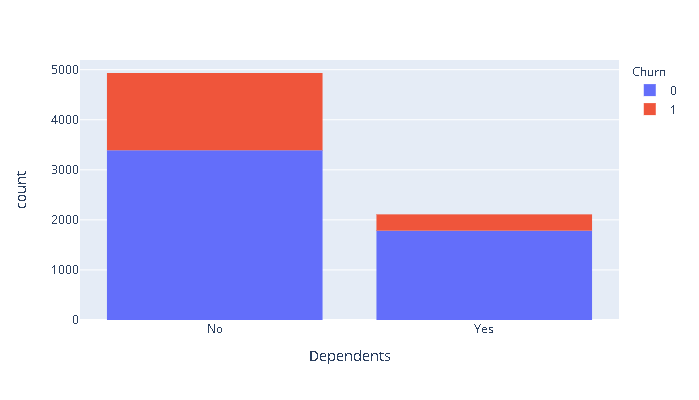

In [ ]:
fig = px.histogram(df1, x="Dependents", color="Churn",width=400, height=400)
fig.show()

- Customer without any dependents, almost 2.03 times more likely churn than cutomer with a dependent.

### **Phone Service and Churn**

In [ ]:
print (f'A customer with a phone service has a probability of {round(df1[df1["PhoneService"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any phone service has a probability of {round(df1[df1["PhoneService"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a phone service has a probability of 26.71 % churn

A customer without any phone service has a probability of 24.93 % churn



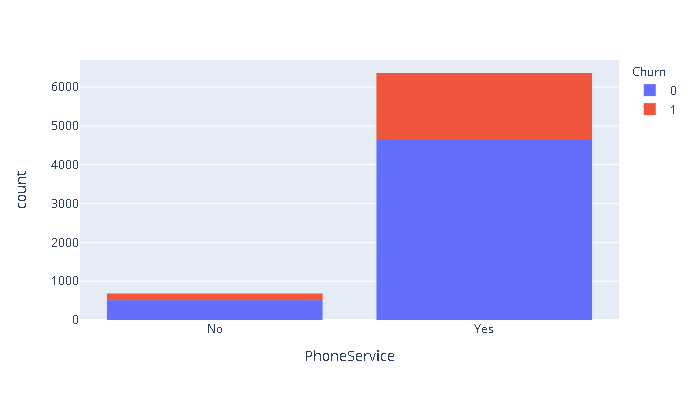

In [ ]:
fig = px.histogram(df1, x="PhoneService", color="Churn",width=400, height=400)
fig.show()

- Churn rate difference between customer has a phone service with the company and customer does not have a home phone service with the company is very small.

### **Multiple Lines and Churn**

In [ ]:
df1['MultipleLines']= df1['MultipleLines'].replace('No phone service','No')

In [ ]:
print (f'A customer with a multiple lines has a probability of {round(df1[df1["MultipleLines"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without multiple lines has a probability of {round(df1[df1["MultipleLines"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a multiple lines has a probability of 28.61 % churn

A customer without multiple lines has a probability of 25.02 % churn



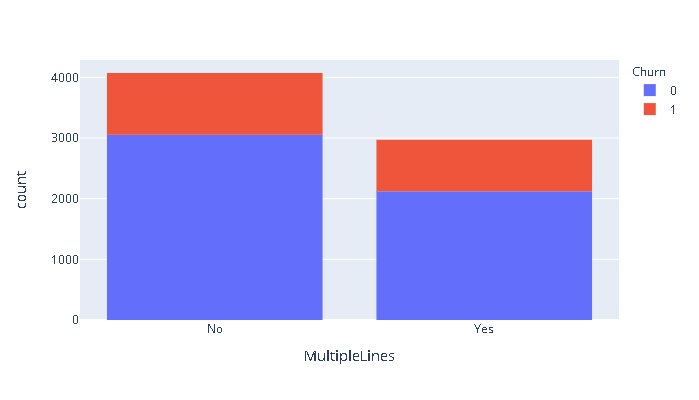

In [ ]:
fig = px.histogram(df1, x="MultipleLines", color="Churn",width=400, height=400)
fig.show()

- Churn rate difference between customer has a multiple lines phone service with the company and customer does not have a multiple line phone service with the company is very small.

### **Internet Service and Churn**

In [ ]:
print (f'A customer with a Fiber Optic internet service has a probability of {round(df1[df1["InternetService"]=="Fiber optic"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a DSL internet service has a probability of {round(df1[df1["InternetService"]=="DSL"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any internet service has a probability of {round(df1[df1["InternetService"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Fiber Optic internet service has a probability of 41.89 % churn

A customer with a DSL internet service has a probability of 18.96 % churn

A customer without any internet service has a probability of 7.4 % churn



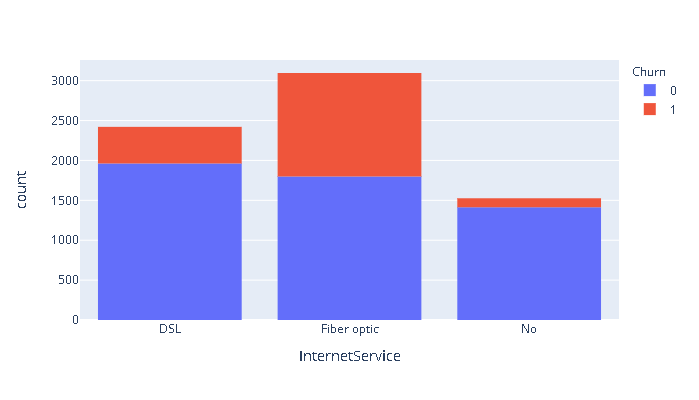

In [ ]:
fig = px.histogram(df1, x="InternetService", color="Churn",width=400, height=400)
fig.show()

- Customer with fiber optic internet with the company compare to customer without any internet service with the company **5.66 times** more likely to churn.
- Customer with fiber optic internet with the company compare to customer with DSL internet service with the company almost **2.21 times** more likely to churn.
- Customer with DSL internet service with the company compare to customer without any internet service with the company **2.56 times** more likley to churn.

### **Online Security and Churn**

In [ ]:
df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

In [ ]:
print (f'A customer with a online security has a probability of {round(df1[df1["OnlineSecurity"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any online security has a probability of {round(df1[df1["OnlineSecurity"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a online security has a probability of 14.61 % churn

A customer without any online security has a probability of 31.33 % churn



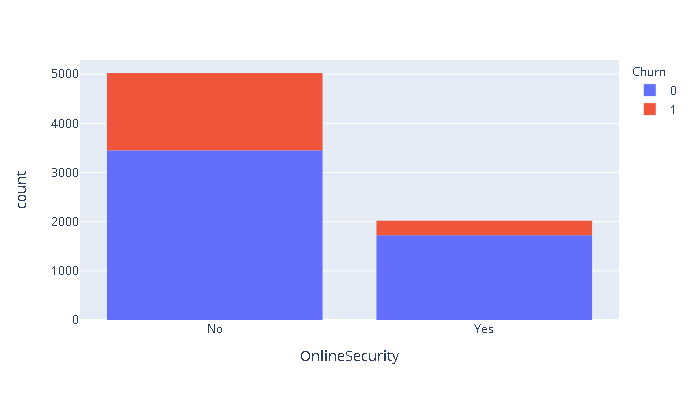

In [ ]:
fig = px.histogram(df1, x="OnlineSecurity", color="Churn",width=400, height=400)
fig.show()

- A customer with an online security service with the company almost **2.14 times** less likely to leave the company than a customer without any online security service with the company.

### **Online Backup and Churn**

In [ ]:
print (f'A customer with a online backup has a probability of {round(df1[df1["OnlineBackup"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any online backup has a probability of {round(df1[df1["OnlineBackup"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a online backup has a probability of 21.53 % churn

A customer without any online backup has a probability of 29.17 % churn



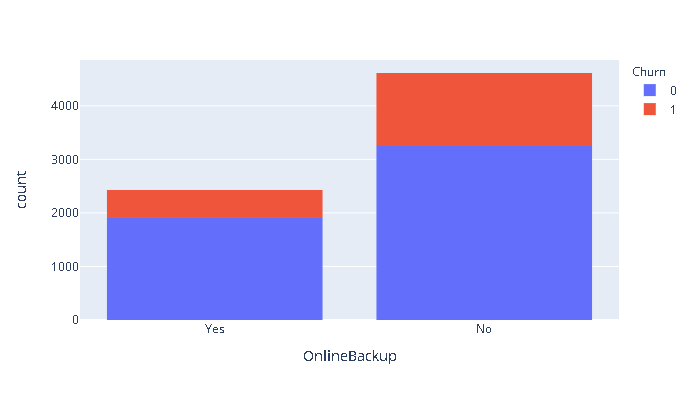

In [ ]:
fig = px.histogram(df1, x="OnlineBackup", color="Churn",width=400, height=400)
fig.show()

- A customer with an online backup service with the company almost **1.35 times** less likely to leave the company than a customer without any online backup service with the company.

### **Device Protection and Churn**

In [ ]:
print (f'A customer with a device protection has a probability of {round(df1[df1["DeviceProtection"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any device protection has a probability of {round(df1[df1["DeviceProtection"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a device protection has a probability of 22.5 % churn

A customer without any device protection has a probability of 28.65 % churn



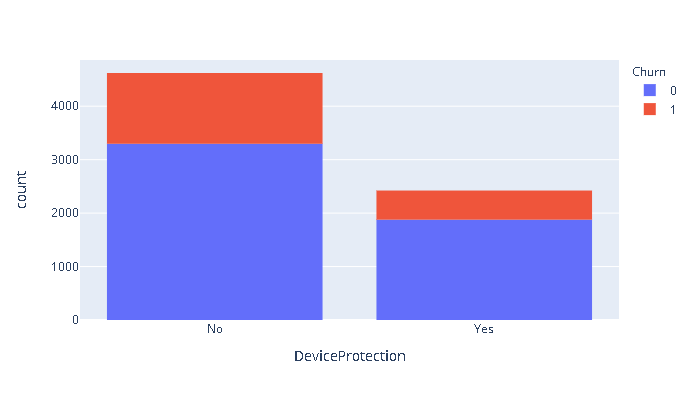

In [ ]:
fig = px.histogram(df1, x="DeviceProtection", color="Churn",width=400, height=400)
fig.show()

- A customer with a device protection service with the company almost **1.27 times** less likely to leave the company than a customer without any a device protection service with the company.

### **Tech Support and Churn**

In [ ]:
print (f'A customer with a Tech Support has a probability of {round(df1[df1["TechSupport"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Tech Support has a probability of {round(df1[df1["TechSupport"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Tech Support has a probability of 15.17 % churn

A customer without any Tech Support has a probability of 31.19 % churn



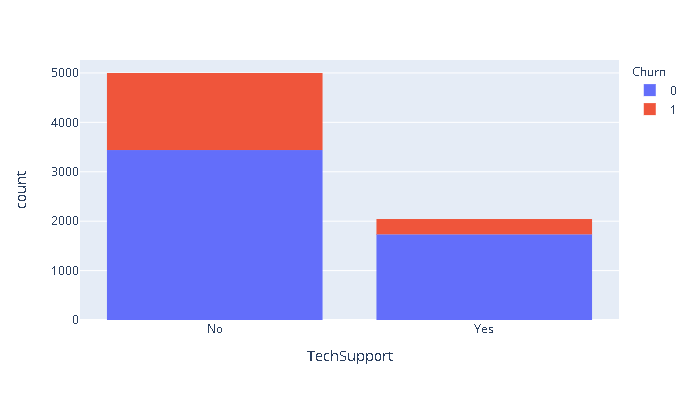

In [ ]:
fig = px.histogram(df1, x="TechSupport", color="Churn",width=400, height=400)
fig.show()

- A customer with a Tech Support service with the company almost **2.06 times** less likely to leave the company than a customer without any a Tech Support service with the company.

### **Streaming TV Service and Churn**

In [ ]:
print (f'A customer with a Streaming TV service with the company has a probability of {round(df1[df1["StreamingTV"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Streaming TV service with the company has a probability of {round(df1[df1["StreamingTV"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Streaming TV service with the company has a probability of 30.07 % churn

A customer without any Streaming TV service with the company has a probability of 24.33 % churn



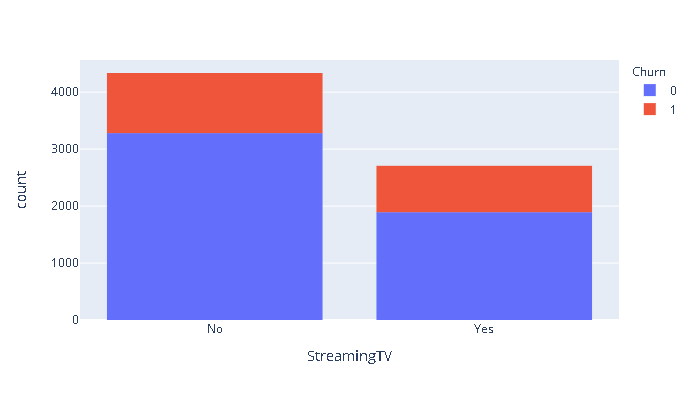

In [ ]:
fig = px.histogram(df1, x="StreamingTV", color="Churn",width=400, height=400)
fig.show()

- A customer with a Streaming TV service with the company almost **1.24 times** more likely to leave the company than a customer without any a Streaming TV service with the company.

### **Streaming Movies Service and Churn**

In [ ]:

print (f'A customer with a Streaming movies service with the company has a probability of {round(df1[df1["StreamingMovies"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Streaming movies service with the company has a probability of {round(df1[df1["StreamingMovies"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a Streaming movies service with the company has a probability of 29.94 % churn

A customer without any Streaming movies service with the company has a probability of 24.38 % churn



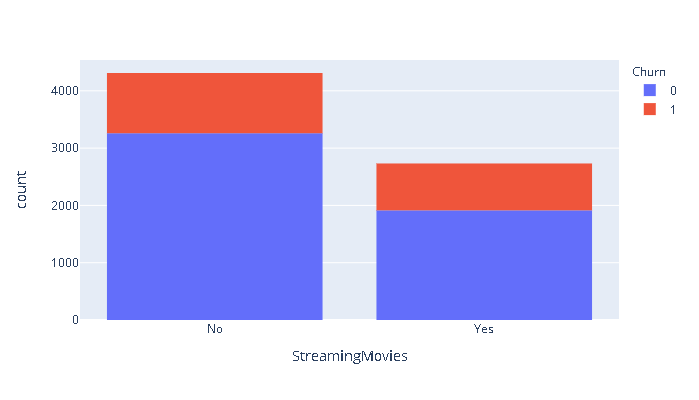

In [ ]:
fig = px.histogram(df1, x="StreamingMovies", color="Churn",width=400, height=400)
fig.show()

- A customer with a Streaming Movies service with the company almost **1.23 times** more likely to leave the company than a customer without any a Streaming movies service with the company.

### **Contract Type & Churn**

In [ ]:

print (f'A customer with a Month to month contract has a probability of {round(df1[df1["Contract"]=="Month-to-month"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Two year contract has a probability of {round(df1[df1["Contract"]=="Two year"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a One year contract has a probability of {round(df1[df1["Contract"]=="One year"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a Month to month contract has a probability of 42.71 % churn

A customer with a Two year contract has a probability of 2.83 % churn

A customer with a One year contract has a probability of 11.27 % churn



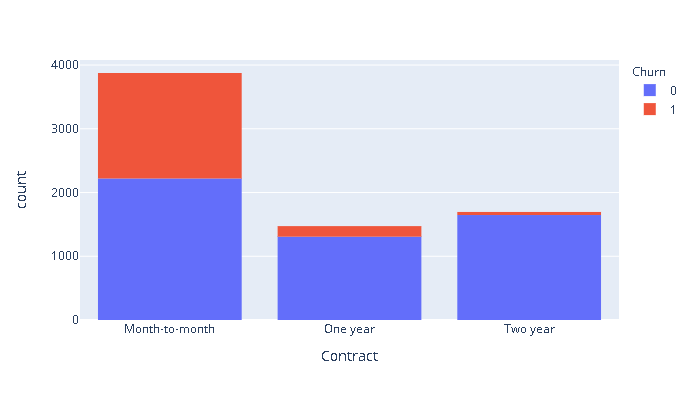

In [ ]:
fig = px.histogram(df1, x="Contract", color="Churn",width=400, height=400)
fig.show()

- Great differences based on the contract were seen in the histogram and mean differences.
- Customer with the 2 year contract almost **15.1 times** less likely to churn compare to customer with a monthly contract.
- On the other hand customer with the 1 year contract almost **3.79 times** less likely to churn compare to customer with a monthly contract.

### **Paperless Billing & Churn**

In [ ]:

print (f'A customer with a Paperless billing  has a probability of {round(df1[df1["PaperlessBilling"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without a Paperless billing has a probability of {round(df1[df1["PaperlessBilling"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Paperless billing  has a probability of 33.57 % churn

A customer without a Paperless billing has a probability of 16.33 % churn



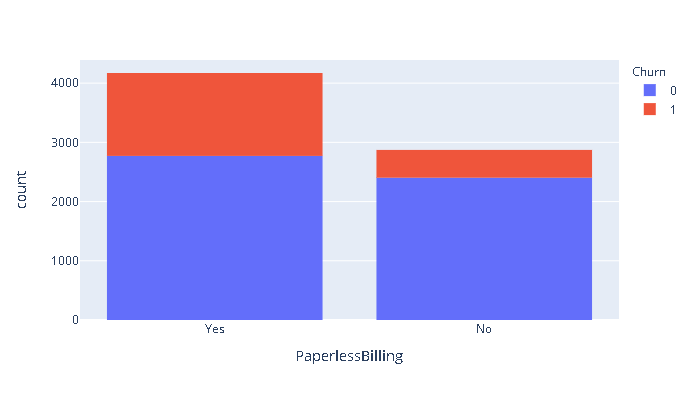

In [ ]:
fig = px.histogram(df1, x='PaperlessBilling', color="Churn",width=400, height=400)
fig.show()

- A customer with a paperless billing with the company almost **2.06 times** more likely to leave the company than a customer without a paperless billing with the company.

### **Payment Method & Churn**

In [ ]:

print (f'A customer with a Payment method as a Electornic Check has a probability of {round(df1[df1["PaymentMethod"]=="Electronic check"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Mailed Check has a probability of {round(df1[df1["PaymentMethod"]=="Mailed check"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Bank transfer (automatic) has a probability of {round(df1[df1["PaymentMethod"]=="Bank transfer (automatic)"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Credit card (automatic) has a probability of {round(df1[df1["PaymentMethod"]=="Credit card (automatic)"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Payment method as a Electornic Check has a probability of 45.29 % churn

A customer with a Payment method as a Mailed Check has a probability of 19.11 % churn

A customer with a Payment method as a Bank transfer (automatic) has a probability of 16.71 % churn

A customer with a Payment method as a Credit card (automatic) has a probability of 15.24 % churn



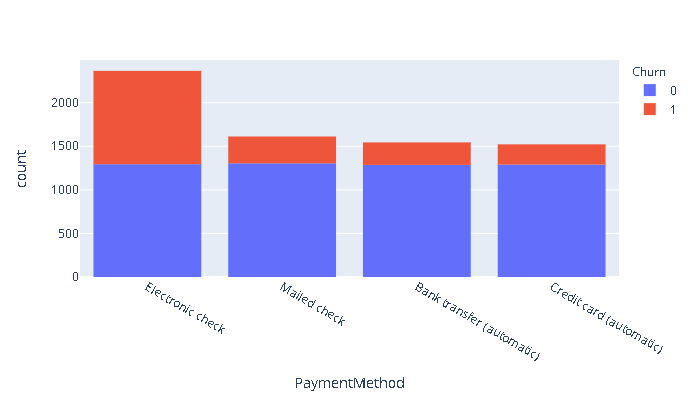

In [ ]:
fig = px.histogram(df1, x='PaymentMethod', color="Churn",width=400, height=400)
fig.show()

- Almost half of the customers with a payment method as a Electornic Check churn, which is a quite big percentage.

<a id="6"></a>
<font color="Darkblue" size=+1.5><b>Overall Insights</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- **`Gender`** : There is not much difference between gender on the churn rate. We won't include gender into our model.
- **`Partner`** :  Customer without any relationship, single customer almost 1.7 times more likely churn than cutomer with a partner.
- **`Dependents`** : Customer without any dependents, almost 2.03 times more likely churn than cutomer with a dependent.
- **`Phone Service`**: Churn rate difference between customer has a phone service with the company and customer does not have a home phone service with the company is very small. We won't include phone service into our model.
- **`Multiple Lines`** : Churn rate difference between customer has a multiple lines phone service with the company and customer does not have a multiple line phone service with the company is very small.
- **`ìnternet Service`** : Customer with fiber optic internet with the company compare to customer without any internet service with the company 5.66 times more likely to churn.
- **`Online Security`**: A customer with an online security service with the company almost 2.14 times less likely to leave the company than a customer without any online security service with the company.
- **`Online Backup`** A customer with an online backup service with the company almost 1.35 times less likely to leave the company than a customer without any online backup service with the company.
- **`Device Protection`** : A customer with a device protection service with the company almost 1.27 times less likely to leave the company than a customer without any a device protection service with the company.
- **`Tech Support`** : A customer with a Tech Support service with the company almost 2.06 times less likely to leave the company than a customer without any a Tech Support service with the company.
- **`Streaming TV Service`** : A customer with a Streaming TV service with the company almost 1.24 times more likely to leave the company than a customer without any a Streaming TV service with the company.
- **`Streaming Movies Service`** : A customer with a Streaming Movies service with the company almost 1.23 times more likely to leave the company than a customer without any a Streaming movies service with the company.
- **`Contract Type`** : Great differences based on the contract were seen in the histogram and mean differences.
    - Customer with the 2 year contract almost 15.1 times less likely to churn compare to customer with a monthly contract.
    - On the other hand customer with the 1 year contract almost 3.79 times less likely to churn compare to customer with a monthly contract.
- **`Paperless Billing`** : A customer with a paperless billing with the company almost 2.06 times more likely to leave the company than a customer without a paperless billing with the company.
- **`Payment Method`** : Almost half of the customers with a payment method as a Electornic Check churn, which is a quite big percentage.


<a id="7"></a>
<font color="Darkblue" size=+2.5><b>How Famous Trio (XGBoost & LightGBM & Catboost) Deal Imbalanced Data?</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- In this part, we will look at the CatBoost, XGBoost and LightGBM and will see how they deal imbalanced data internally.
- In general, boosting algorithms do good job even on imbalanced data.
- They produce good results on the imbalanced daata by giving an opportunity to focus more on the minority class and accordingly tune the training algorithm.


- CatBoost, XGBoost and LightGBM use **`scale_pos_weight`** hyperparameter to tune the training algorithm for the imbalanced data.

- **`scale_pos_weight`** is **1** by default.

- Both major class and minority class get the same weight.

- When dealing with imbalanced data, story changes a bit.
- **`scale_pos_weight`** gets the number of ( total number of examples in the majority class divided by the total number of examples in the minority class.)

- For example, in our data;
     - Number of Non-churned customer:  5174
     - Number of Churned customer: 1869
     -  **`scale_pos_weight`** should get 5174 / 1869  which is almost **3**
     
- By adjusting the weight, minority class gets 3 times more impact and 3 times more correction than errors made on the majority class.

- Two important point,
    - by changing **`scale_pos_weight`** we can also see changes on the **`recall, accuracy, roc-auc, precision score`**
    - If we use extreme values for the **`scale_pos_weight`**, we can overfit the minority class and model could make worse predictions.



<a id="8"></a>
<font color="Darkblue" size=+2.5><b>CatBoost</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

![](https://avatars.mds.yandex.net/get-bunker/56833/dba868860690e7fe8b68223bb3b749ed8a36fbce/orig)

Image Credit: https://avatars.mds.yandex.net

<a id="9"></a>
<font color="Darkblue" size=+1.5><b>CatBoost (with default Parameters) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model_names =[]

df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])


df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')


X= df1.drop('Churn', axis=1)
y= df1['Churn']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_base = CatBoostClassifier(verbose=False,random_state=0)

catboost_base.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

Accuracy  Recall  Roc_Auc  Precision
Catboost_default    0.8074  0.5192    0.717     0.6946

- With the **default parameters, Catboost** get almost**.52 Recall and .72 Roc_Auc**

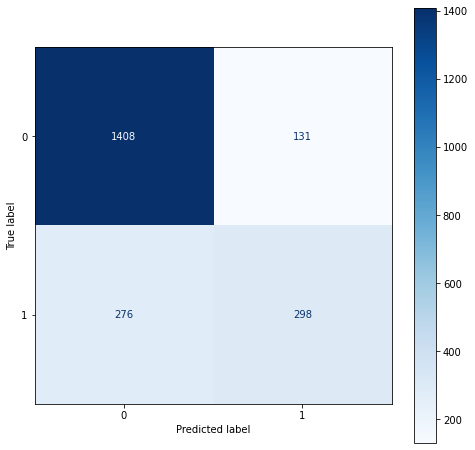

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- By using deafult value of **`scale_pos_weight`**, **CatBoost** correctly predicted **almost half of the churned customer**
- But model couldn't be able to correctly predict the other half.

<a id="10"></a>
<font color="Darkblue" size=+1.5><b>CatBoost (with adjusted Scale_Pos_Weight = 3) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')


X= df1.drop('Churn', axis=1)
y= df1['Churn']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3)

catboost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_3']
result_df2 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df2

Accuracy  Recall  Roc_Auc  Precision
Catboost_adjusted_weight_3    0.7534  0.8415    0.781      0.529

- With the adjusted **`scale_pos_weight=3`**, **CatBoost** got  **.84 Recall and .78 Roc_Auc**

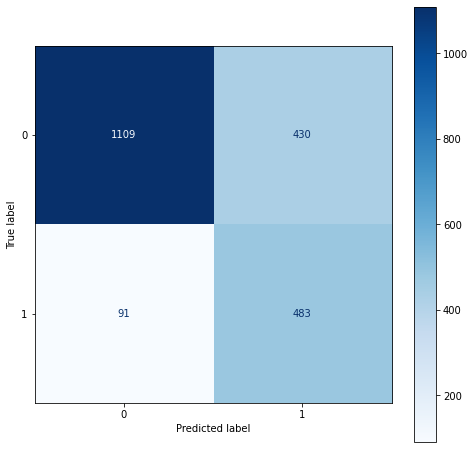

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- By using recommended formula for **`scale_pos_weight`**, **CatBoost** correctly predicted **84% of the churned customers**.
- As you have seen that, we didn't change any other parameter and get almost 32% lift in our recall score.

<a id="11"></a>
<font color="Darkblue" size=+1.5><b>CatBoost (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- For the sake of showing the power of model with a small increase on the weight, let's see the differences on the Recall score and Roc_Auc.
- We will increase **`scale_pos_weight`**  from **3** to **5**.
- Minority class gets 5 times more impact and 5 times more correction than errors made on the majority class.

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')


X= df1.drop('Churn', axis=1)
y= df1['Churn']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=5)

catboost_5.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_5']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

Accuracy  Recall  Roc_Auc  Precision
Catboost_adjusted_weight_5    0.6796  0.9181   0.7544     0.4555

- With the adjusted **`scale_pos_weight=5`**, **CatBoost** got  almost **.92 Recall and .75 Roc_Auc**

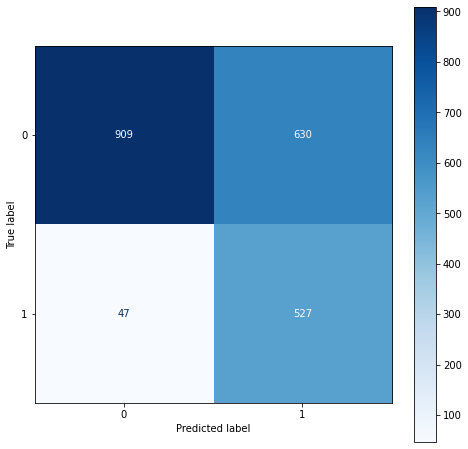

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- By using weight a little bit higher than recommended formula for **`scale_pos_weight = 5`**, **CatBoost** correctly predict almost **92% of the churned customers**.
- On the other hand we have lost 7% for the precision and 3 points for the Roc_Auc score.

## **SHAP Summary Plot - CatBoost (with adjusted Scale_Pos_Weight = 5 )**

In [ ]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

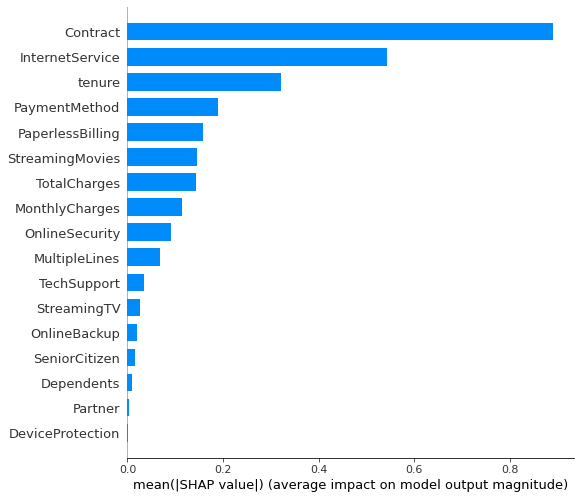

In [ ]:
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

<a id="12"></a>
<font color="Darkblue" size=+2.5><b>XGBoost</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

![](https://miro.medium.com/max/1400/1*1kjLMDQMufaQoS-nNJfg1Q.png)

Image Credit: https://miro.medium.com/

<a id="13"></a>
<font color="Darkblue" size=+1.5><b>XGBoost (with default Parameters) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_base = XGBClassifier(random_state=0)

xgbc_base.fit(X_train, y_train)
y_pred = xgbc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_Default']
result_df4 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df4

[19:39:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  Recall  Roc_Auc  Precision
XGBoost_Default     0.779  0.4704   0.6822     0.6236

- With the **default parameters, XGBoost** get **.47 Recall and .68 Roc_Auc**.

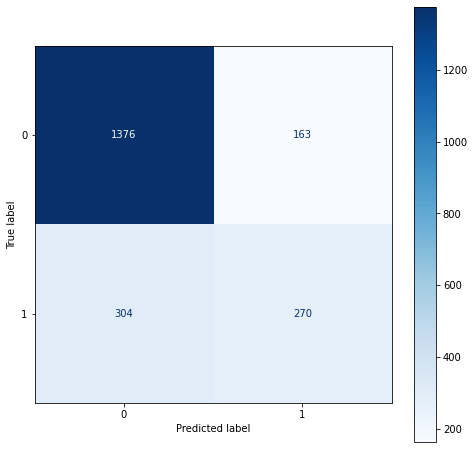

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- Bu using deafult value of **`scale_pos_weight`**, **XGBoost** correctly predicted **less than half of the churned customers**.

<a id="14"></a>
<font color="Darkblue" size=+1.5><b>XGBoost (with adjusted Scale_Pos_Weight = 3) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_3 = XGBClassifier(random_state=0,scale_pos_weight=3)

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_adjusted_weight_3']
result_df5 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df5

[19:39:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  Recall  Roc_Auc  Precision
XGBoost_adjusted_weight_3    0.7643   0.669   0.7344     0.5549

- With the adjusted **`scale_pos_weight`**, **XGBoost** got almost **.67 Recall and .73 Roc_Auc**

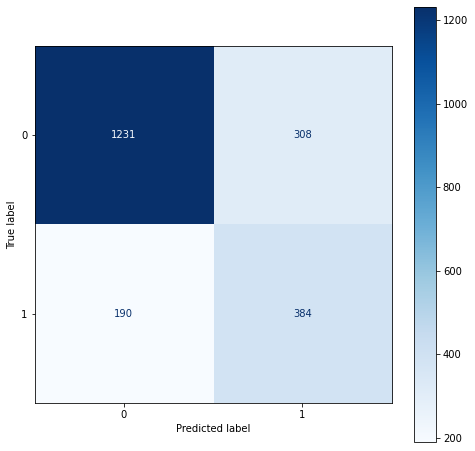

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- Bu using recommended adjusted value of **`scale_pos_weight`**, **XGBoost** correctly predicted almost **67% of the churned customers**.

<a id="15"></a>
<font color="Darkblue" size=+1.5><b>XGBoost (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- For the sake of showing the power of model with a small increase on the weight, let's see the differences on the Recall score and Roc_Auc.
- We will increase **`scale_pos_weight`**  from **3** to **5**.
- Minority class gets 5 times more impact and 5 times more correction than errors made on the majority class.

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_5 = XGBClassifier(random_state=0,scale_pos_weight=5)

xgbc_5.fit(X_train, y_train)
y_pred = xgbc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_adjusted_weight_5']
result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df6

[19:39:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  Recall  Roc_Auc  Precision
XGBoost_adjusted_weight_5    0.7544  0.7422   0.7505     0.5345

- With the adjusted **`scale_pos_weight = 5`**, **XGBoost** got **.74 Recall and .75 Roc_Auc**

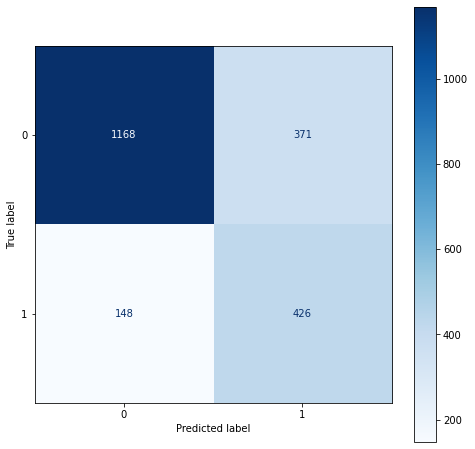

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- When we play around a little bit with the value of  **`scale_pos_weight`**, **XGBoost** correctly predicted almost **74% of the churned customers** by using **scale_pos_weight=5** (Roc_Auc = .75)


## **SHAP Summary Plot- XGBoost (with adjusted Scale_Pos_Weight = 5)**

In [ ]:
explainerxgbc = shap.TreeExplainer(xgbc_5)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

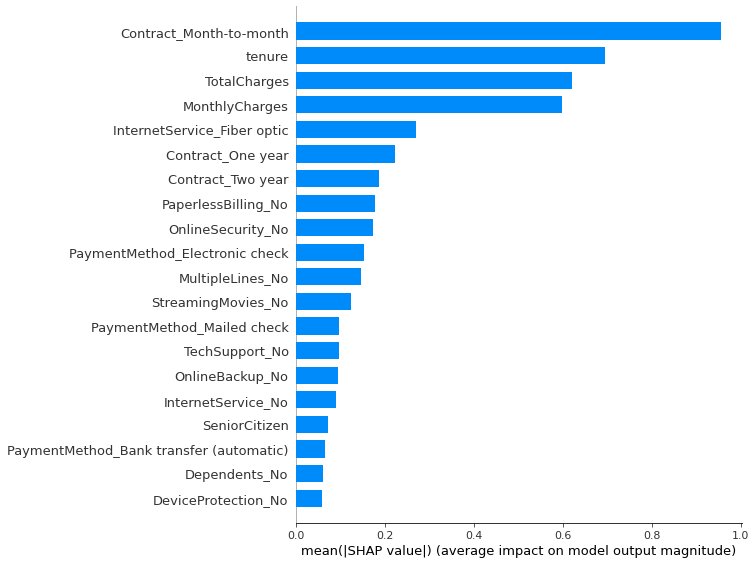

In [ ]:
shap.summary_plot(shap_values_XGBoost_train, X_train, plot_type="bar")

<a id="16"></a>
<font color="Darkblue" size=+2.5><b>LightGBM</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

![](https://repository-images.githubusercontent.com/64991887/dc855780-e34b-11ea-9ab8-e08ca33288b0)

Image Credit: https://repository-images.githubusercontent.com/64991887/

<a id="17"></a>
<font color="Darkblue" size=+1.5><b>LightGBM (with default Parameters) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

for col in X.columns:
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[col] = X[col].astype('category')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_base=LGBMClassifier(random_state=0)

lgbmc_base.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_default']
result_df7 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df7

Accuracy  Recall  Roc_Auc  Precision
LightGBM_default    0.7998  0.5401   0.7184      0.661

- With the adjusted **`scale_pos_weight`**, **LightGBM** got almost **.54 Recall and .72 Roc_Auc**

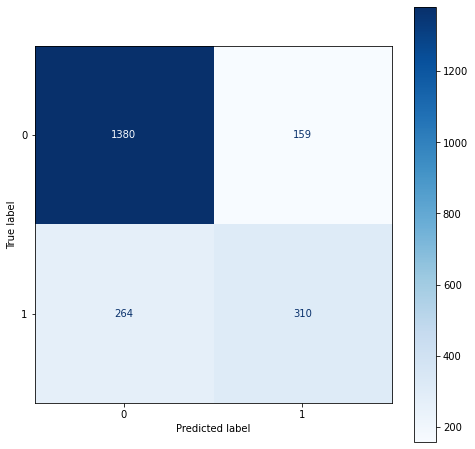

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbmc_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- Bu using deafult value of **`scale_pos_weight`**, **LightGBM** correctly predicted alittle bit more than half of the churned customers.

<a id="18"></a>
<font color="Darkblue" size=+1.5><b>LightGBM (with adjusted Scale_Pos_Weight =3) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

for col in X.columns:
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_3=LGBMClassifier(random_state=0,scale_pos_weight=3)

lgbmc_3.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_adjusted_weight_3']
result_df8 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df8

Accuracy  Recall  Roc_Auc  Precision
LightGBM_adjusted_weight_3     0.761  0.7718   0.7644     0.5422

- With the adjusted **`scale_pos_weight`**, **LightGBM** got **.77 Recall and .76 Roc_Auc**

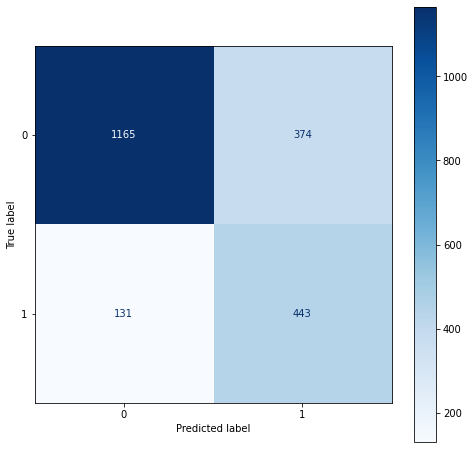

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbmc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- By using recommended formula for **`scale_pos_weight`**, **LightGBM** correctly predicted almost 77% of the churned customer.
- As you have observed that, we didn't change any other parameter and get almost 23% lift in our recall score without overfitting.
- We can improve this score without destroying the Roc_Auc.

<a id="19"></a>
<font color="Darkblue" size=+1.5><b>LightGBM (with adjusted Scale_Pos_Weight =5) Deals With Imbalanced Data</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

- For the sake of showing the power of model with a small increase on the weight, let's see the differences on the Recall score and Roc_Auc.
- We will increase **`scale_pos_weight`**  from **3** to **5**.
- Minority class gets 5 times more impact and 5 times more correction than errors made on the majority class.

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

for col in X.columns:
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_5=LGBMClassifier(random_state=0,scale_pos_weight=5)

lgbmc_5.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_adjusted_weight_5']
result_df9 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df9

Accuracy  Recall  Roc_Auc  Precision
LightGBM_adjusted_weight_5    0.7255   0.831   0.7586     0.4969

- With the adjusted **`scale_pos_weight = 5`**, **LightGBM** got **.83 Recall and almost .76 Roc_Auc**

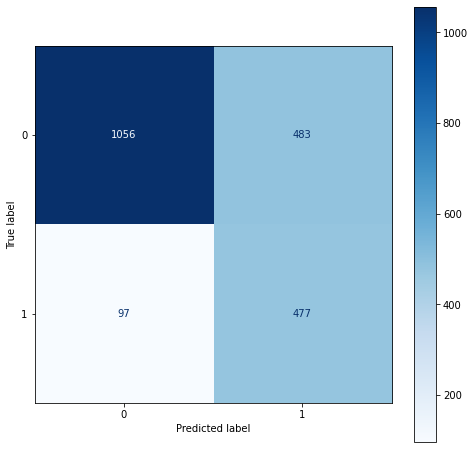

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbmc_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- By using **`scale_pos_weight =5`**, **LightGBM** correctly predicted **83% of the churned customer**.

## **SHAP Summary Plot- LightGBM (with adjusted Scale_Pos_Weight = 5)**

In [ ]:
explainerlgbmc = shap.TreeExplainer(lgbmc_5)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)

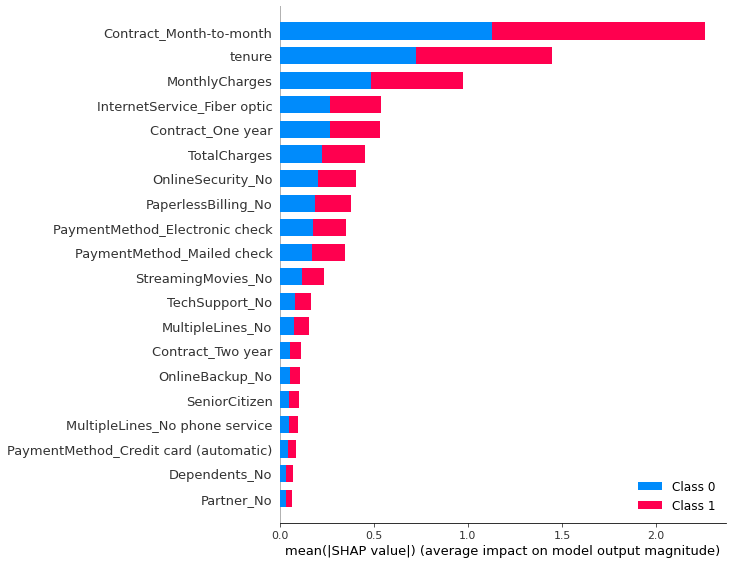

In [ ]:
shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")

<a id="20"></a>
<font color="Darkblue" size=+1.5><b>Final Result Table and Model Comparison</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [ ]:
result_final= pd.concat([result_df1,result_df2,result_df3,result_df4,result_df5,result_df6, result_df7,result_df8,result_df9],axis=0)
result_final

Accuracy  Recall  Roc_Auc  Precision
Catboost_default              0.8074  0.5192   0.7170     0.6946
Catboost_adjusted_weight_3    0.7534  0.8415   0.7810     0.5290
Catboost_adjusted_weight_5    0.6796  0.9181   0.7544     0.4555
XGBoost_Default               0.7790  0.4704   0.6822     0.6236
XGBoost_adjusted_weight_3     0.7643  0.6690   0.7344     0.5549
XGBoost_adjusted_weight_5     0.7544  0.7422   0.7505     0.5345
LightGBM_default              0.7998  0.5401   0.7184     0.6610
LightGBM_adjusted_weight_3    0.7610  0.7718   0.7644     0.5422
LightGBM_adjusted_weight_5    0.7255  0.8310   0.7586     0.4969

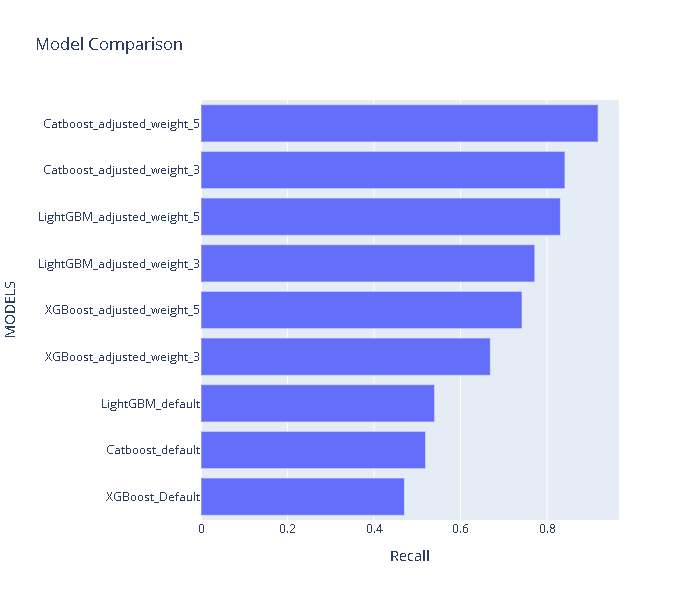

In [ ]:
result_final.sort_values(by=['Recall'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Recall', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()

<a id="21"></a>
<font color="Darkblue" size=+2.5><b>Conclusion</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In this notebook, we have looked in detail at how famous trio (XGBoost & LightGBM & Catboost) handle the imbalanced data.

- We looked at the CatBoost, XGBoost and LightGBM  and showed how they deal with imbalanced data internally.
- In general, boosting algorithms do good job even on imbalanced data.
- They produce good results on the imbalanced daata by giving an opportunity to focus more on the minority class and accordingly tune the training algorithm.

- CatBoost, XGBoost and LightGBM use **`scale_pos_weight`** hyperparameter to tune the training algrotih for the imbalanced data.

- **`scale_pos_weight`** is **1** by default. Both major class and minority class get the same weight.
- When dealing with imbalanced daya, story changes a bit.
- **`scale_pos_weight`** gets the number of ( total number of examples in the majority class divided by the total number of examples in the minority class.)     
- By adjusting the weight, minority class got 3 times more impact and 3 times more correction than errors made on the majority class.
- We also observed that when we changed **`scale_pos_weight`** from **3** to **5** , we have observed significant increase on the **`recall`** score.
- Two important point,
    - by changing **`scale_pos_weight`** we observed changes on the **`recall, accuracy, roc-auc, precision score`**
    - If we use extreme values for the **`scale_pos_weight`**, we can overfit the minority class and model could make worse predictions.


- I have to emphasize that it is important to get deep knowledge on the data and problem on the hand. Based on the stakeholder's / customer's demand and domain knowledge we can make changes accordingly.

#### By the way, when you like the topic, you can show it by supporting 👍

####  **Feel free to leave a comment**.

#### All the best 🤘

![](https://media.giphy.com/media/EMvZor0TLYdACIug6S/giphy-downsized-large.gif)

Gif Credit: https://media.giphy.com/

<a id="22"></a>
<font color="darkblue" size=+1.5><b>Further Reading</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>


[Machine Learning - Beginner &Intermediate-Friendly BOOKS](https://www.kaggle.com/general/255972)
